# Visualize augmentation functions

Data augmentation plays an important role in our approach as many of our training images are **synthetic**.

Here we provide the visualizations of the data augmentation functions we used - which can be found in `data/augmentations/`.

In [1]:
import os
import cv2
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from torchvision import transforms
from data import Sample
import data.augmentations.basic as aug_basic
import data.augmentations.appearance as aug_appear
import data.augmentations.perspective as aug_persp
import utils.visualize as vis_utils

Let's first define a sample. This is an image from the [TartanAir](https://theairlab.org/tartanair-dataset/) dataset (scene_name: oldtown).

In [2]:
img_path = './example/000000_img.png'
depth_path = './example/000000_depth.npy'
normal_path = './example/000000_normal.png'
intrins_path = './example/000000_intrins.npy'
assert os.path.exists(img_path)
assert os.path.exists(depth_path)
assert os.path.exists(normal_path)
assert os.path.exists(intrins_path)

We use `img`, `depth`, `normal`, and `intrins`. Depth can be omitted when training a model for surface normal estimation.

In [3]:
img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0

depth = np.load(depth_path)[:,:,None]
depth_mask = depth > 1e-3

normal = cv2.cvtColor(cv2.imread(normal_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
normal_mask = np.sum(normal, axis=2, keepdims=True) > 0
normal = (normal.astype(np.float32) / 65535.0) * 2.0 - 1.0

intrins = np.load(intrins_path)

sample = Sample(img=img, 
                depth=depth,
                depth_mask=depth_mask,
                normal=normal,
                normal_mask=normal_mask,
                intrins=intrins)

### Define augmentation

We first need to convert the numpy arrays into torch tensors.

In [4]:
tf_list = [aug_basic.ToTensor()]

Let's now resize and crop the image/depth/normal. Camera intrinsics will also be updated by these functions.

In [5]:
tf_list += [
    # aug_basic.Resize(H=480, W=640), # resize to (H, W)
    aug_persp.SameFov(new_fov=60, H=480, W=640),    # resize and crop the image so that the principal point is at the center and the field-of-view is new_fov 
    # aug_basic.RandomCrop(H=416, W=544),   # randomly crop the image
]

This function randomly rotates the input image. It can be useful if you want to stay robust to tilted images.

In [6]:
tf_list += [
    aug_persp.RotationAndScale(yaw_range=10, 
                                pitch_range=10, 
                                roll_range=180, 
                                random_fov=True, 
                                min_fov=50, 
                                max_fov=60,
                                H=480, W=640,
                                p=1.0),
]

This function adds random horizontal flipping.

In [7]:
tf_list += [
    aug_basic.HorizontalFlip(p=0.5)
]

This function does mild color augmentation.

In [8]:
tf_list += [
    aug_basic.ColorAugmentation(gamma_range=(0.9, 1.1), 
                                brightness_range=(0.75, 1.25), 
                                color_range=(0.9, 1.1), p=0.5)
]


This function does a more sophisticated set of appearance augmentation.

Try visiting `data/augmentations/appearance.py` to play around with the settings.

You can define your own appearance augmentation to find the one that gives you the best result.

In [9]:
tf_list += [
    aug_appear.AppearAug(p=0.8, ver=2),
]

Finish by normalizing the input image and converting it to a dictionary.

In [10]:
tf_list += [
    aug_basic.Normalize(),
    aug_basic.ToDict(),
]

Now we compose the data preprocessing/augmentation functions.

Try removing some of the functions from `tf_list` or try changing the strength of the appearance augmentation to see how they affect the image quality.

In [11]:
test_transform = transforms.Compose(tf_list)

Now, we can visualize the image, surface normals, and depth-maps after data augmentation.

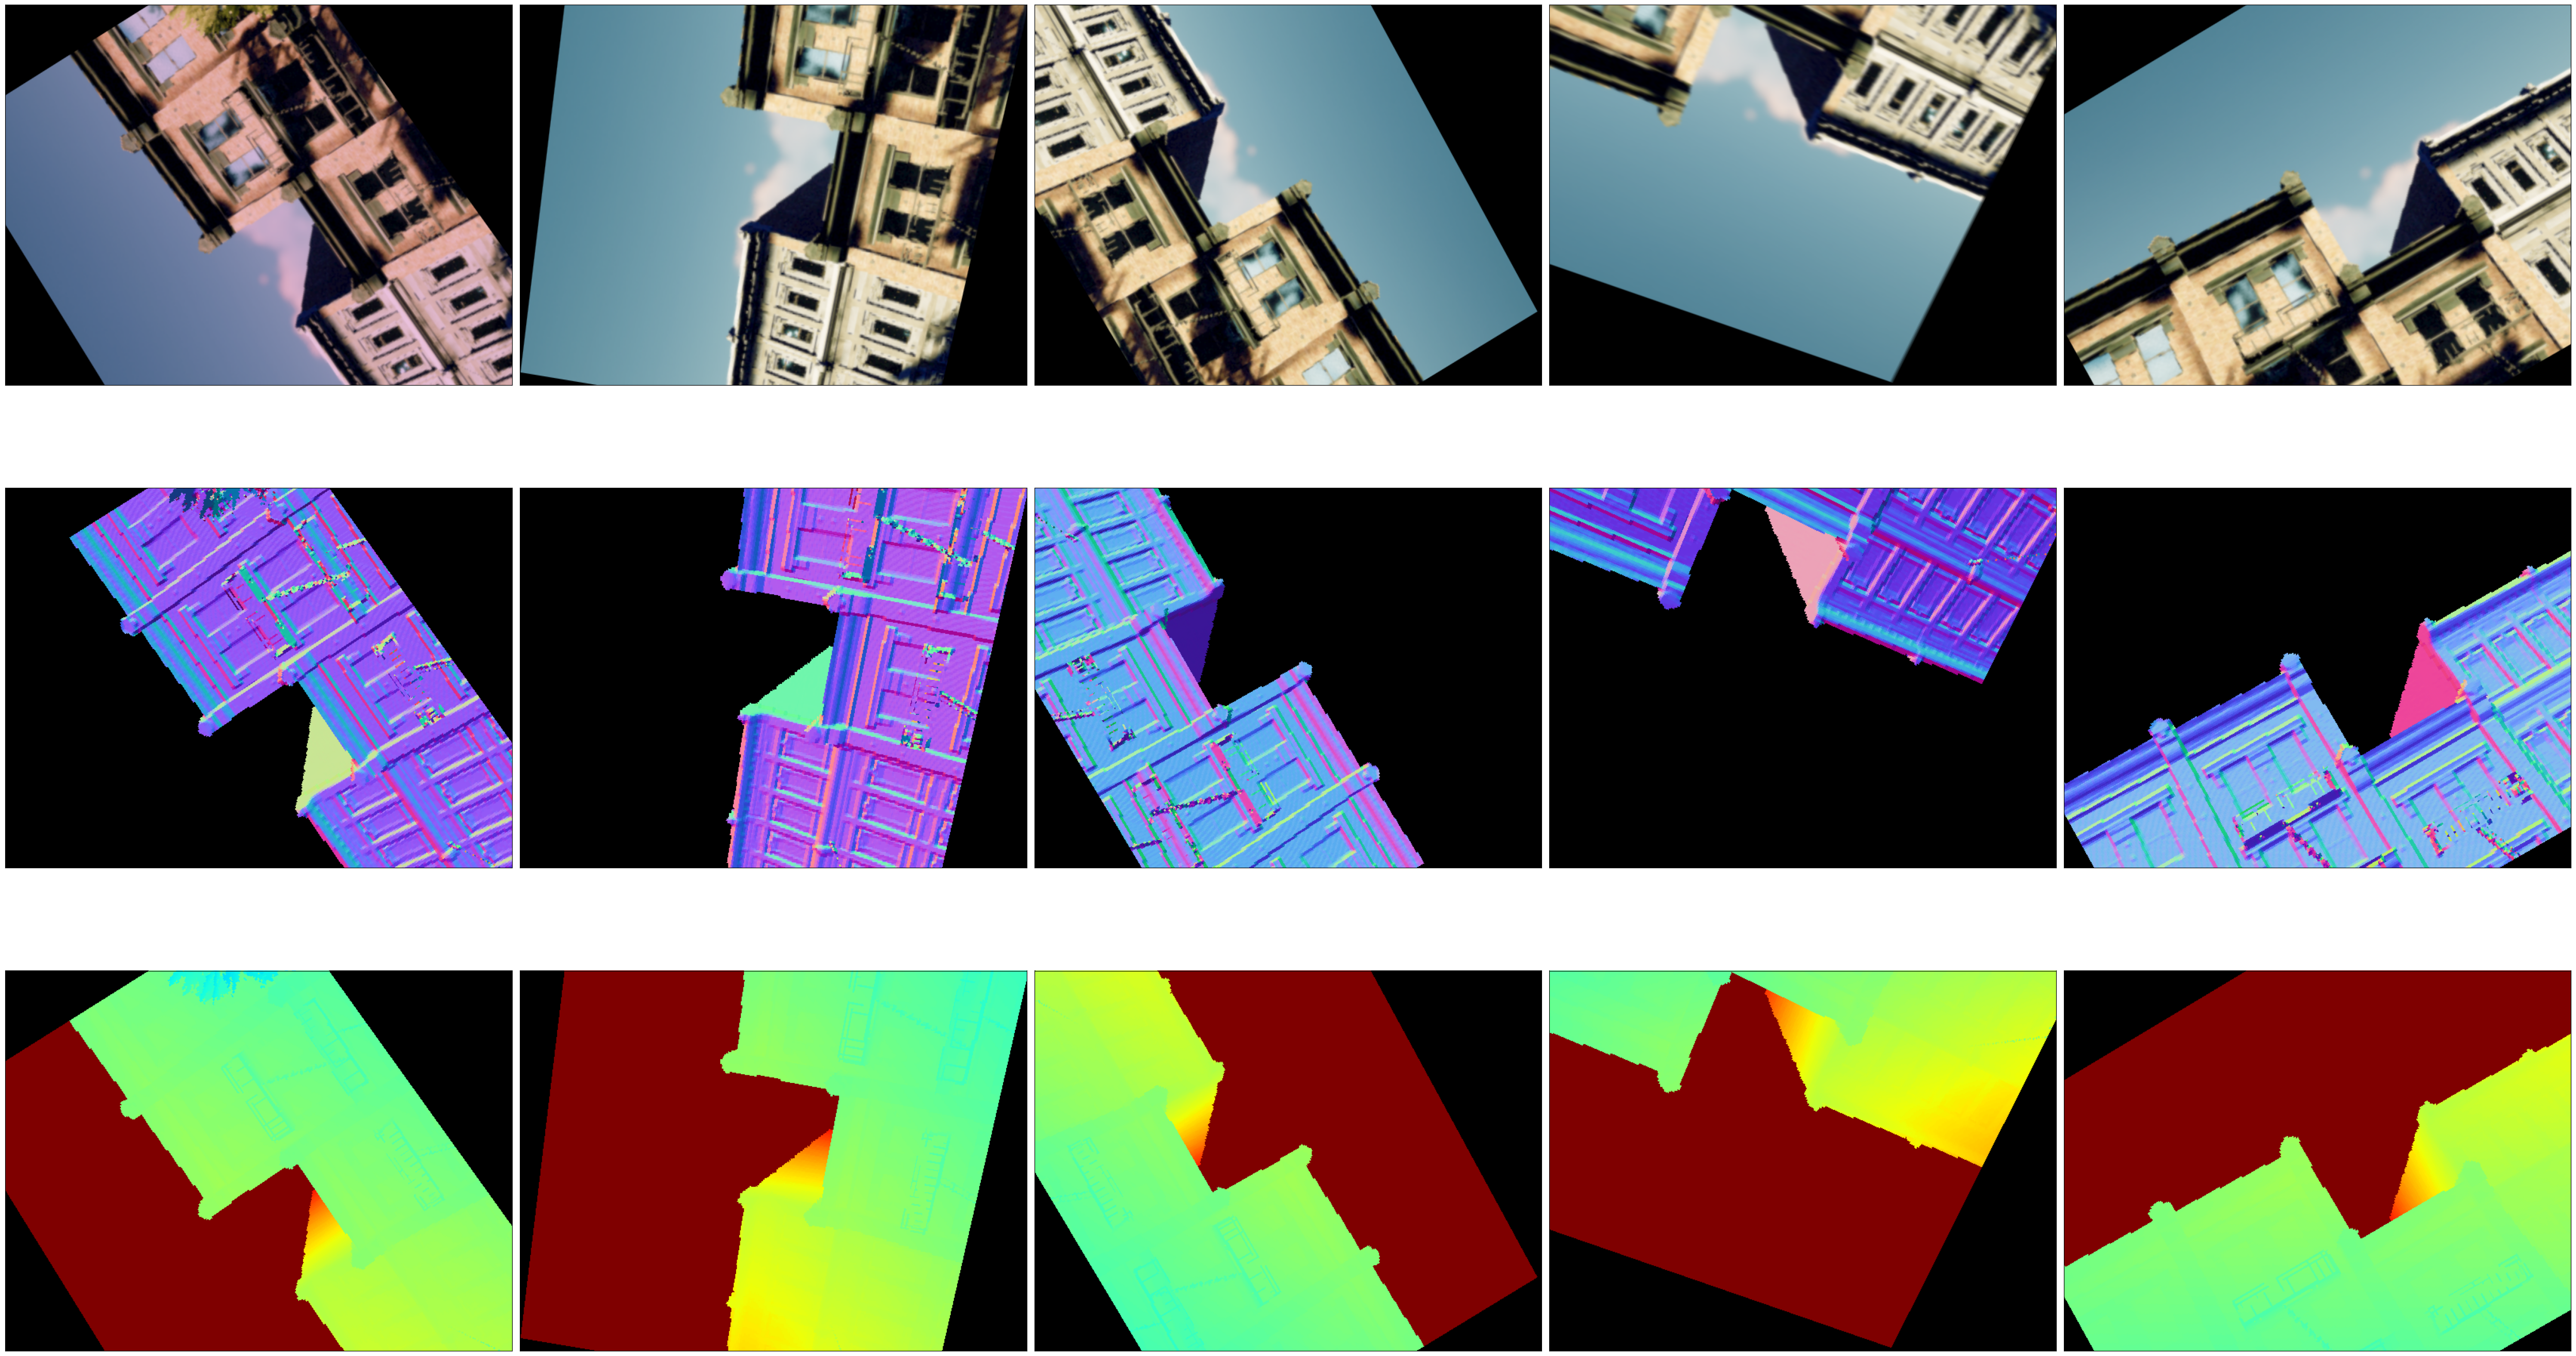

In [12]:
imgs = []
fig, axes = plt.subplots(3,5, figsize=(50, 30))

for i in range(5):
    sample_ = deepcopy(sample)
    sample_ = test_transform(sample_)

    img = sample_['img']
    img = vis_utils.unnormalize(img)

    normal = sample_['normal']
    normal_mask = sample_['normal_mask']
    normal = vis_utils.normal_to_rgb(normal, normal_mask)

    depth = sample_['depth']
    depth_mask = sample_['depth_mask']
    depth = vis_utils.depth_to_rgb(depth, depth_mask, d_min=1e-3, d_max=35.0, colormap='jet')

    axes[0,i].imshow(img)
    axes[1,i].imshow(normal)
    axes[2,i].imshow(depth)

    for j in range(3):
        axes[j,i].get_xaxis().set_visible(False)
        axes[j,i].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()